In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
df = pd.read_csv("/new.csv")

In [3]:
df.shape

(9433, 4)

### Analyse Dataset

Text(0.5, 1.0, '        Review counts by target column')

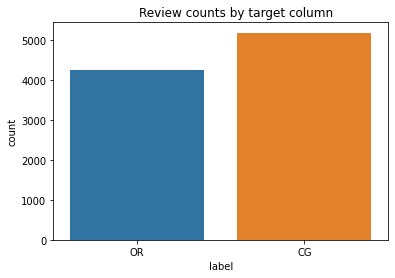

In [4]:
sns.countplot(data=df, x="label")
plt.title("        Review counts by target column")
# plt.yticks(rotation=45)

Text(0.5, 1.0, '        Review counts by categories')

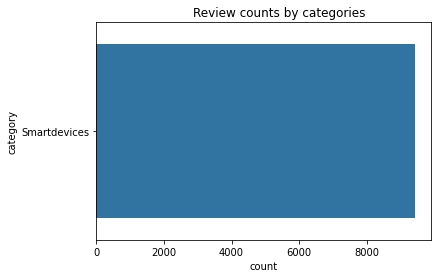

In [5]:
sns.countplot(data=df, y="category")
plt.title("        Review counts by categories")

### Detection

#### Baseline-1
After doing a literature survey of identifying real vs generated text, we figured out that OpenAI has already worked upon similar problem of identifying gpt-2 output dataset from real world texts.
Their best performing model was a finetuned roberta on webtext data. As a very first baseline we tried using their pretrained model on our validation dataset.    

Below is the performance and classification report of the model on the validation set.

##### Classification Report
                precision    recall  f1-score   support

          CG       0.76      0.92      0.84      4010
          OR       0.90      0.72      0.80      4077

    accuracy                           0.82      8087
    macro avg      0.83      0.82      0.82      8087
    weighted avg   0.83      0.82      0.82      8087

[Source](https://d4mucfpksywv.cloudfront.net/papers/GPT_2_Report.pdf)

#### Baseline-2 
We wanted to try out a very simple baseline to compare results. So, we decided to try out [Logitic Regression variant of NBSVM (SVM with NB features)](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline) which has been a stronger baseline for a number of sentiment analysis classification tasks.     
In this baseline as per the [Paper](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) a simple model variant where a LogisticRegression is built over NB log-count ratios as feature values.   

Below is the performance and classification report of the model on the validation set.  

###### Classification Report
                precision    recall  f1-score   support

          CG       0.96      0.93      0.95      4010
          OR       0.94      0.96      0.95      4077

    accuracy                           0.95      8087
    macro avg      0.95      0.95      0.95      8087
    weighted avg   0.95      0.95      0.95      8087


### Final Model
Inspired from the idea by OpenAI of finetuning RoBERTa, we decided to finetune RoBERTa on our dataset consisting of real reviews from Amazon dataset against our Generated reviews from Finetuned GPT-2 in the phase-1 of the project.

Idea being RoBERTa is a masked and non-generative language model that does not share the same architecture or the same tokenizer as GPT-2. This becomes important because during generation phase we generated our reviews by finetuning GPT-2 so, using a different architecture for the classifier intuitively makes it more robust and bias free from GPT-2 style of generation.

The RoBERTa model was proposed in [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018.
It builds on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.
[Source](https://huggingface.co/transformers/model_doc/roberta.html)

#### Hyperparameters
Mainly *learning rate(LR)*, *max seuquence length(MAX_SEQ_LEN)* and *batch size(BATCH_SIZE)* was taken care while finetuning our model performance.   

Tried out different range of high(in multiples of *1e-02* to *1e-01*) and low(in multiples of *1e-05* to *1e-04* learning rates. Values of 128 and 256 were tried out as parameters which is a standard way of tuning *max sequence length* parameter. Values of 4,8,16,32 were tried to tune *batch size* parameter.   

With possible capacity of our machine(*GPU*) a combination of *MAX_LEN = 256, TRAIN_BATCH_SIZE = 8, VALID_BATCH_SIZE = 8, LEARNING_RATE = 1e-05* resulted in the best model performance. Below is the classification report of our model.

##### Classification Report
                precision    recall  f1-score   support

          CG       0.97      0.96      0.97      4010
          OR       0.97      0.97      0.97      4077

    accuracy                           0.97      8087
    macro avg      0.97      0.97      0.97      8087
    weighted avg   0.97      0.97      0.97      8087


### Analyze models predictions

Post analysis of our above three models against different categories of Amazon Reviews is added below:

In [6]:
encoded_label_dict = {"CG" : 0, "OR" : 1}
def encode_label(x):
    return encoded_label_dict.get(x,-1)

In [7]:
df["target"] = df["label"].apply(lambda x: encode_label(x))

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True, stratify=None, random_state=2021)

In [19]:
df1 = pd.read_csv("/gpt2_detector_predictions2.csv")
df2 = pd.read_csv("/ft_roberta_predictions2.csv")
df3 = pd.read_csv("/NbLogReg_predictions2.csv")

In [20]:
merged_df = pd.concat([valid_df.reset_index(drop=True), df1.reset_index(drop=True), df2.reset_index(drop=True), df3.reset_index(drop=True)], axis= 1)

In [21]:
merged_df.head()

,category,rating,label,text_,target,GPT2_Detector_Model_Probability,GPT2_Detector_Model_Prediction,Finetune_Roberta_Model_Probability,Finetune_Roberta_Model_Prediction,NbLogReg_Model_Probability,NbLogReg_Model_Prediction
0,Smartdevices,5.0,CG,I dislike on only one thing suppose we ridin...,0.0,0.995070,1,0.485789,0.0,0.510254,1.0
1,Smartdevices,5.0,CG,This is a quality board for gaming that is b...,0.0,0.355554,0,0.491738,0.0,0.773684,1.0
2,Smartdevices,1.0,OR,The screen came with scratches and the wrist...,1.0,0.108733,0,0.215938,0.0,0.476942,0.0
3,Smartdevices,4.0,OR,I got mine a couple of days back at ...,1.0,0.955705,1,0.991359,1.0,0.977495,1.0
4,Smartdevices,5.0,CG,The band Looks great very smooth screen tou...,0.0,0.038540,0,0.117643,0.0,0.050230,0.0


In [22]:
merged_df["gpt2_matched"] = merged_df["target"] == merged_df["GPT2_Detector_Model_Prediction"]
merged_df["roberta_matched"] = merged_df["target"] == merged_df["Finetune_Roberta_Model_Prediction"]
merged_df["nb_matched"] = merged_df["target"] == merged_df["NbLogReg_Model_Prediction"]

In [23]:
gpt2_category_acc = merged_df.groupby("category")["gpt2_matched"].mean()*100

In [14]:
print(f"Accuracies across different categories for openAI GPT-2 output detector")
pd.DataFrame({"Category" : gpt2_category_acc.index, "Accuracy" : gpt2_category_acc.values})

Accuracies across different categories for openAI GPT-2 output detector


,Category,Accuracy
0,Smartdevices,52.146264


In [15]:
roberta_category_acc = merged_df.groupby("category")["roberta_matched"].mean()*100

In [16]:
print(f"Accuracies across different categories for RoBERTa classifier Finetuned on IMDB real and generated reviews")
pd.DataFrame({"Category" : roberta_category_acc.index, "Accuracy" : roberta_category_acc.values})

Accuracies across different categories for RoBERTa classifier Finetuned on IMDB real and generated reviews


,Category,Accuracy
0,Smartdevices,86.27451


In [24]:
nb_category_acc = merged_df.groupby("category")["nb_matched"].mean()*100

In [25]:
print(f"Accuracies across different categories for NBLogisticRegression trained on IMDB real and generated reviews")
pd.DataFrame({"Category" : nb_category_acc.index, "Accuracy" : nb_category_acc.values})

Accuracies across different categories for NBLogisticRegression trained on IMDB real and generated reviews


,Category,Accuracy
0,Smartdevices,86.486486


Text(0, 0.5, 'GPT-2 detector accuracy')

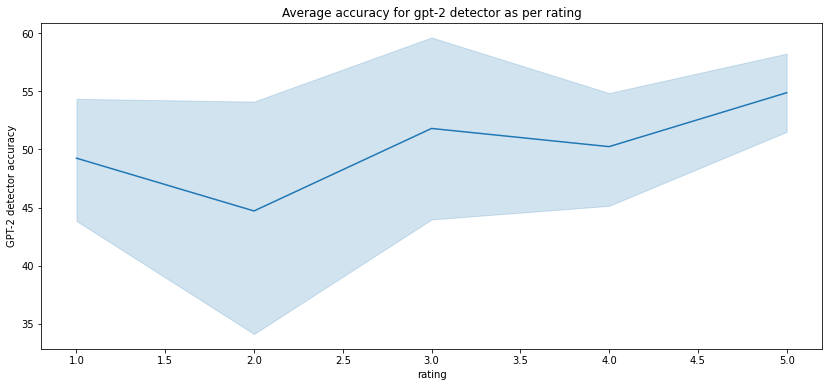

In [30]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy for gpt-2 detector as per rating")
sns.lineplot(x=merged_df["rating"],y=merged_df["gpt2_matched"]*100)
plt.ylabel("GPT-2 detector accuracy")

In [31]:
gpt2_acc_std_devs_by_rating = merged_df.groupby("rating")["gpt2_matched"].std()
roberta_acc_std_devs_by_rating = merged_df.groupby("rating")["roberta_matched"].std()
nblogreg_acc_std_devs_by_rating = merged_df.groupby("rating")["nb_matched"].std()

Text(0.5, 0, 'rating')

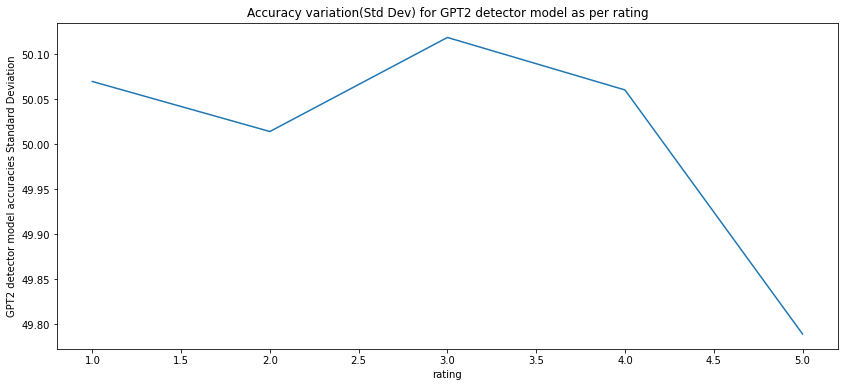

In [33]:
plt.figure(figsize=(14,6))
plt.title("Accuracy variation(Std Dev) for GPT2 detector model as per rating")
sns.lineplot(x=gpt2_acc_std_devs_by_rating.index,y=gpt2_acc_std_devs_by_rating.values*100)
plt.ylabel("GPT2 detector model accuracies Standard Deviation")
plt.xlabel("rating")

Text(0, 0.5, 'Finetuned RoBERTa model accuracy')

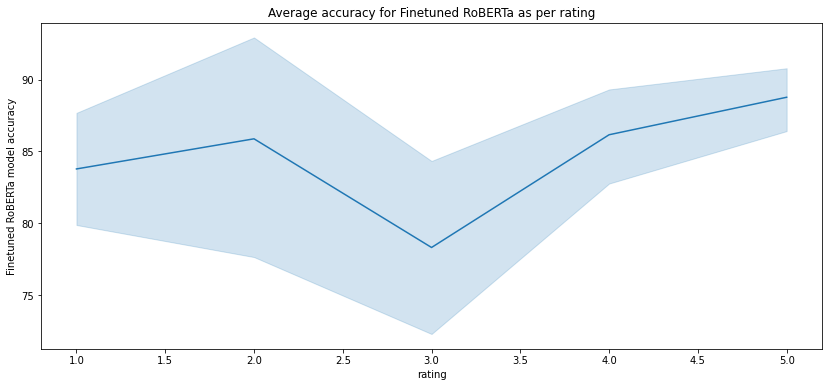

In [34]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy for Finetuned RoBERTa as per rating")
sns.lineplot(x=merged_df["rating"],y=merged_df["roberta_matched"]*100)
plt.ylabel("Finetuned RoBERTa model accuracy")

Text(0.5, 0, 'rating')

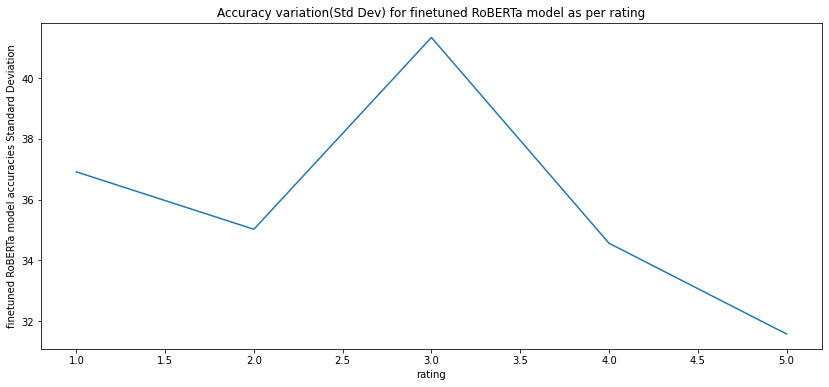

In [35]:
plt.figure(figsize=(14,6))
plt.title("Accuracy variation(Std Dev) for finetuned RoBERTa model as per rating")
sns.lineplot(x=roberta_acc_std_devs_by_rating.index,y=roberta_acc_std_devs_by_rating.values*100)
plt.ylabel("finetuned RoBERTa model accuracies Standard Deviation")
plt.xlabel("rating")

Text(0, 0.5, 'NBLogisticRegression model accuracy')

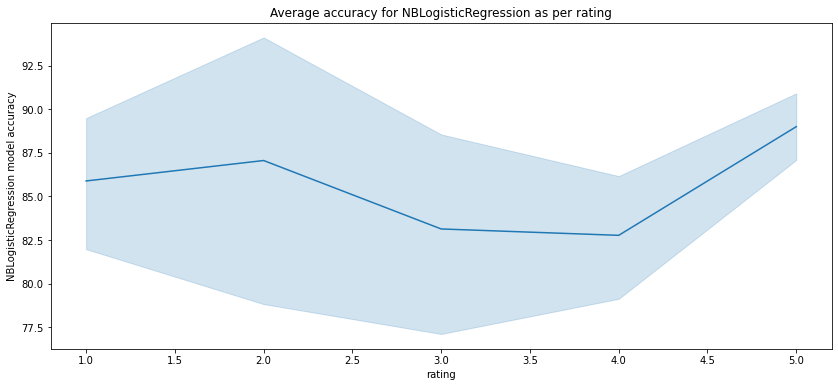

In [36]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy for NBLogisticRegression as per rating")
sns.lineplot(x=merged_df["rating"],y=merged_df["nb_matched"]*100)
plt.ylabel("NBLogisticRegression model accuracy")

Text(0.5, 0, 'rating')

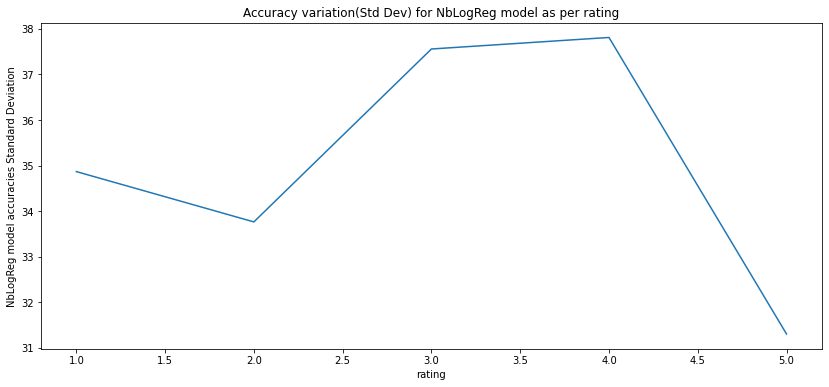

In [37]:
plt.figure(figsize=(14,6))
plt.title("Accuracy variation(Std Dev) for NbLogReg model as per rating")
sns.lineplot(x=nblogreg_acc_std_devs_by_rating.index,y=nblogreg_acc_std_devs_by_rating.values*100)
plt.ylabel("NbLogReg model accuracies Standard Deviation")
plt.xlabel("rating")

Text(0, 0.5, '3 detectors accuracy')

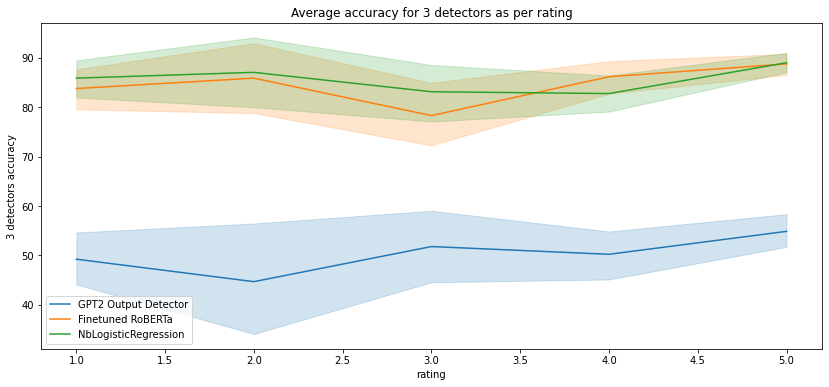

In [38]:
plt.figure(figsize=(14,6))
plt.title("Average accuracy for 3 detectors as per rating")
sns.lineplot(x=merged_df["rating"],y=merged_df["gpt2_matched"]*100, label="GPT2 Output Detector")
sns.lineplot(x=merged_df["rating"],y=merged_df["roberta_matched"]*100, label="Finetuned RoBERTa")
sns.lineplot(x=merged_df["rating"],y=merged_df["nb_matched"]*100, label="NbLogisticRegression")
plt.ylabel("3 detectors accuracy")

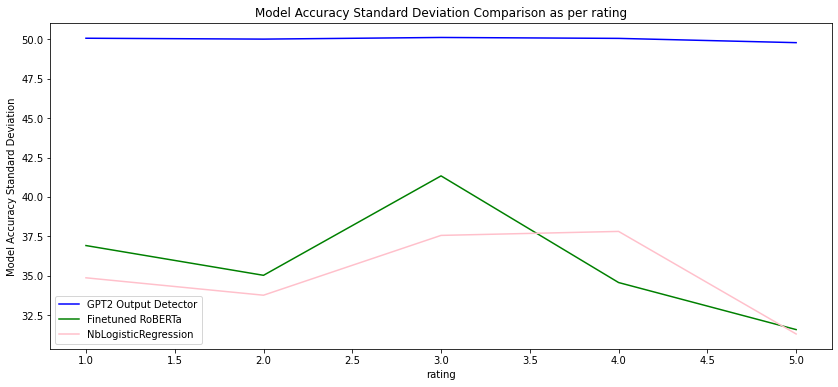

In [39]:
plt.figure(figsize=(14,6))
plt.title("Model Accuracy Standard Deviation Comparison as per rating")
x1 = gpt2_acc_std_devs_by_rating.index
y1 = gpt2_acc_std_devs_by_rating.values*100
y2 = roberta_acc_std_devs_by_rating.values*100
y3 = nblogreg_acc_std_devs_by_rating.values*100
plt.plot(x1, y1, "b", label="GPT2 Output Detector")
plt.plot(x1, y2, "g", label="Finetuned RoBERTa")
plt.plot(x1, y3, "pink", label="NbLogisticRegression")
plt.ylabel("Model Accuracy Standard Deviation")
plt.xlabel("rating")
plt.legend()
plt.show()

#### McNemar's Test

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar

In [ ]:
data = merged_df[["gpt2_matched","roberta_matched"]].astype(int)
table = sm.stats.Table.from_data(data)

In [ ]:
result = mcnemar(table.table_orig, exact=False, correction=True)
print("statistic=%.3f, p-value=%.3f" % (result.statistic, result.pvalue))
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors')
else:
    print('Different proportions of errors')

statistic=939.201, p-value=0.000
Different proportions of errors


In [ ]:
data = merged_df[["nb_matched","roberta_matched"]].astype(int)
table = sm.stats.Table.from_data(data)

In [ ]:
result = mcnemar(table.table_orig, exact=False, correction=True)
print("statistic=%.3f, p-value=%.3f" % (result.statistic, result.pvalue))
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors')
else:
    print('Different proportions of errors')

statistic=42.537, p-value=0.000
Different proportions of errors


In [ ]:
data = merged_df[["gpt2_matched","nb_matched",]].astype(int)
table = sm.stats.Table.from_data(data)

In [ ]:
result = mcnemar(table.table_orig, exact=False, correction=True)
print("statistic=%.3f, p-value=%.3f" % (result.statistic, result.pvalue))
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors')
else:
    print('Different proportions of errors')

statistic=658.383, p-value=0.000
Different proportions of errors


### Observations

##### Did we beat the baseline? By how much?    
Comparing our final model which is a FineTuned RoBERTa on our dataset(i.e. mix of generated and real reviews) with our first baseline OpenAI's gpt-2 output detector, we did manage to improve the former baseline performance by ~14%. Pretrained openAI gpt-2 output detector's accuracy on the validation set was coming out to be ~83% while our final model gave an accuracy of ~97% on the validation set.   

Comparing our final model with another simpler but stonger baseline which a variant of NB (Naive Bayes) with Logistic Regression oftenly used as baseline for text classification, here also we were able to improve accuracy by ~2%. NB Logistic Regression model trained on our dataset was performing with ~95% accuracy on the validation set while our final model as stated above was performing at an accuracy of ~97% on the same validation set.   
##### Is the difference statistically significant? (McNemar's test)   
As we are using McNemar's test to compare classifiers, we state that there is statistically significant difference in the disagreements between any two models. 
##### Were there notable differences by category, rating or length, or did the detection work equally well across all of them? 
Comparing model performances across different categoris of reviews, we can see that all the three models perform relatively the same on all top-10 categories in comparison to their overall accuracies. One thing we can notice is with gpt-2 output detector model we can see a delta of +- 10% for few of the categories while this same delta lowers down to ~3% when it comes to NBLogisticRegression model or our final finetuned RoBERTa model. Our Finetuned RoBERTa model gives gt95% acccuracies across all categories while NBLogistic Regression model keeps an accuracy of gt93% across all categories of reviews.  

Comparing model performances across different lengths of sentences we can definitely observe that models are much more accurate and consistent for longer sentences in comparison to shorter sentences.  
##### What are the implications for practice - meaning, can we trust this model and what are its limitations? 
Yes, it's a step towards researching and exploring text generation capabilities in NLP. Also, adding classification strategies for the same to be able to identify generated text from real and keep it clean, safe to be used for good.   

All the datasets, model parameters, model weights and initialisation seeds have been kept for experimentation reproducibilty.  
Would love to see more researches in the same direction.
##### How would we develop it further (meaning both the generator and the classifier) if we had more time?   
Given more time and ideas to develop it further, we can definitely try improving our ULMFiT approach to finetune LM on Amazon reviews.  

Another thing we can try is benchmarking classification performances for different set of sampling techniques used  in text generation. Right now, we focused primarily on top-k nucleus sampling to generate our generated reviews dataset but, different sampling techniaues can be applied and classification performances can be analysed for different datasets generated from different sampling techniques.